# ***Random Forrest***

## ***Universidad Central***

## ***Maestría en analítica de datos***

## ***Métodos estadísticos para analítica de datos.***
## ***Docente: Luis Andrés Campos Maldonado.***

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
    
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15,6)

url_base = "https://raw.githubusercontent.com/lacamposm/Metodos-Estadisticos/main/data/"

## ***Bagging y Random Forrest***

Supongamos que hace una pregunta compleja a miles de personas al azar y luego agrega las respuestas, en muchos casos se encontrará que la respuesta agregada es mejor que la respuesta de un experto esto es llamado _sabiduría de la multitud_ [(wisdom of the crowd)](https://en.wikipedia.org/wiki/Wisdom_of_the_crowd). Ahora, pensando en el _machine learning_, si agregamos las predicciones de un grupo de predictores (clasificador o regresores) a menudo se obtiene mejores predicciones que con el mejor predictor original. Un grupo de predictores se denomina _ensemble_; luego, esta técnica se denomina _Ensemble Learning_.

Por ejemplo, puede entrenar un grupo de clasificadores _DecisionTree_, cada uno en un subconjunto aleatorio del set de train. Para hacer predicciones, solo se obtienen las predicciones de todos los árboles individuales, luego ***se predice la clase que obtiene la mayor cantidad de votos***. Tal conjunto de árboles de decisión se llama Random Forest, y a pesar de su sencillez, es uno de los más potentes algoritmos de Machine Learning disponibles en la actualidad.

***NOTA:***

Los metodos de ensamble funcionan mejor cuando los predictores son lo más independientes posible entre sí. Una forma de obtener clasificadores diversos es entrenarlos usando algoritmos muy diferentes. Esto aumenta la posibilidad de que cometan muy diferentes tipos de errores, mejorando la precisión del conjunto.

### ***Bagging y pasting.***

Una forma de obtener un conjunto diverso de clasificadores es usar algoritmos de entrenamiento muy diferentes. Otro enfoque es usar el mismo algoritmo de entrenamiento para todo predictor y entrenarlos en diferentes subconjuntos aleatorios del set de train. Cuando el muestreo se realiza con reemplazo, este método se llama _bagging_ (bootstrap-aggregating). Cuando el muestreo se realiza sin reposición, es llamado _pasting_.

Tanto en _bagging_ como en _pasting_ se permiten muestrear registros del set de train varias veces a través de múltiples predictores, pero solo el _bagging_ permite a los registro del set de train muestrearse varias veces para el mismo predictor.

Una vez que se entrenan todos los predictores, el _ensemble_ puede hacer una predicción para un nuevo registro simplemente agregando las predicciones de todos los predictores. La _aggregation function_ es normalmente la MODA estadística (es decir, la predicción más frecuente) para la clasificación, o el promedio para la regresión. Cada predictor individual tiene un mayor sesgo que si se entrenara en el set de train original, pero la agregación reduce tanto el sesgo como la varianza. Generalmente, el resultado neto es que el conjunto tiene un sesgo similar pero una varianza menor que un solo predictor entrenado en el set de train  original.

### ***Algoritmo Bagging***

Supongamos que tenemos una variable respuesta $Y$ y $p$ variables predictoras $\mathbf{X} = (X_1, X_2, \ldots, X_p)$ con $n$ registros. El Bagging se forma del algoritmo básico para ensembles, excepto que, en lugar de ajustar varios modelos a la misma data, cada nuevo modelo se ajusta a un remuestreo bootstrap.

***Algoritmo:***

1. **Inicialización**:
   - Inicialice $M$, el número de modelos a ajustar.
   - Establezca la iteración $m = 1$.

2. **Generación de Submuestras Bootstrap**:
   - Tome una nueva remuestra de bootstrap (es decir, con reemplazo) de $n$ registros del conjunto de entrenamiento para formar una submuestra $Y_m$ y $\mathbf{X}_m$ (el "bag").

3. **Entrenamiento del Modelo**:
   - Entrene un modelo usando $Y_m$ y $\mathbf{X}_m$ para crear un conjunto de reglas de decisión $\hat{f}_m(\mathbf{X})$.

4. **Incremento del Contador**:
   - Incrementa el contador del modelo $m = m + 1$.
   - Si $m \leq M$, vuelve al paso 2.

5. **Combinación de Predicciones**:
   - **Para Clasificación**:
     - Si $\hat{f}_m$ predice la probabilidad de que $Y = 1$, la estimación bagged viene dada por la votación mayoritaria:

     $$\hat{f}=\frac{1}{M}\left(\hat{f_1}(\mathbf{X})+\hat{f_2}(\mathbf{X})+\cdots+ \hat{f_M}(\mathbf{X})\right)$$

     - Si $\hat{f}_m$ predice la clase de la instancia, la estimación bagged viene dada por la votación mayoritaria:

     $$\hat{f}= moda\left(\hat{f_1}(\mathbf{X}), \hat{f_2}(\mathbf{X}), \cdots, \hat{f_M}(\mathbf{X})\right)$$

   - **Para Regresión**:
     - Si $\hat{f}_m$ predice un valor continuo, la estimación bagged viene dada por el promedio de las predicciones:

     $$\hat{f}=\frac{1}{M}\left(\hat{f_1}(\mathbf{X})+\hat{f_2}(\mathbf{X})+\cdots+\hat{f_M}(\mathbf{X})\right)$$

#### ***Notas Adicionales:***

- **Tamaño de la Submuestra**: En el paso 2, se menciona que se toma una remuestra de $n$ registros. Esto es típico en el bagging, donde el tamaño de la submuestra es igual al tamaño del conjunto de datos original. Sin embargo, en algunas variantes, el tamaño de la submuestra puede ser menor que $n$.

- **Modelos Base**: Los modelos base utilizados en el bagging pueden ser de cualquier tipo, pero los árboles de decisión son comúnmente utilizados debido a su alta varianza y baja capacidad de generalización individual, lo que se compensa al combinarlos en un ensemble.


***NOTA:***

1. En Scikit-Learn, puede establecer `oob_score=True` al crear un _BaggingClassifier_ para solicitar una evaluación _oob_ automática después del entrenamiento.

2. La función de decisión _oob_ para cada registro del set de train también está disponible a través del atributo `oob_decision_function_`. En este caso que el estimador base tenga un método como `predict_proba()`, la función de decisión devuelve las probabilidades de clase para cada registro del set de train.

### ***Random Forrest.***

_Random Forrest_ es un _ensemble_ basado en _bagging_ de _DecisionTrees_, con una importante extensión: además de muestrear los registros del set de train también muestrea las features. En los _DecisionTree_ tradicionales, para determinar cómo crear una subpartición de un partición $A$, el algoritmo elige la variable y el punto de división minimizando un criterio como la impureza de Gini. Con Random Forrest, en cada etapa del algoritmo, la elección de la feature es _limitada a un subconjunto aleatorio de features._

***NOTA:***

1. Generalmente se entrena con `max_samples` ajustado al tamaño del set de train.

2. Una regla empírica es elegir $\sqrt{P}$ donde $P$ es el número de variables predictoras. 


### ***Algoritmo Random Forrest.***

En comparación con el algoritmo de DecisionTree, el algoritmo de Random Forrest agrega dos pasos más: el bagging y el bootstrap sampling de features en cada división:

1. Tome una submuestra de  bootstrap  (con reemplazo) de los registros.

2. Para la primera división, muestree $p< P$ variables al azar sin reemplazo.

3. Para cada una de las variables muestreadas $X_{j(1)}, X_{j(2)},⋯,X_{j(p)}$, aplicar el siguiente algortimo de división:
    
    - A) Para cada valor $s_{j(k)}$ de $X_{j(k)}$:
        -   Divida los registros en la partición $A$, con $X_{j(k)}< s_{j(k)}$ como una partición y los registros restantes donde $X_{j(k)}≥ s_{j(k)}$ como otra partición.
        - Mida la homogeneidad de las clases dentro de cada subpartición de A.

    -  B) Seleccione el valor de $s_{j(k)}$ que produce la máxima homogeneidad dentro de la partición
de clase.

4. Seleccione la variable $X_{j(k)}$ y el valor de división $s_{j(k)}$ que produce la máxima homogeneidad de clase dentro de la partición.

5. Seleccione un nuevo subconjunto de $p$ variables al azar para la siguiente división del árbol, y repita el proceso desde el paso 3 para determinar la mejor división en este nodo.

6. Continúe con divisiones adicionales, siguiendo el mismo procedimiento hasta que el árbol logre su máximo crecimiento.

7. Vuelva al paso 1, tome otra submuestra de arranque y comience el proceso de nuevo otra vez.

## ***Nuevo modelo de incumplimiento de pago.***

***Problema:***  Construir un modelo de clasificación para determinar si un usuario  pagará su préstamo o no.

Nuestra data de trabajo.

In [2]:
# Preparamos la Data
df_prestamos = pd.read_parquet(url_base + "Logistic_Regression_1.parquet",)
df_prestamos.drop_duplicates(inplace=True)
df_prestamos["tasa_de_interes"] = df_prestamos["tasa_de_interes"].str.replace("%", "").astype("float")
df_prestamos

,estado_del_prestamo,ingreso_anual,estado_de_verificacion,anios_de_experiencia_laboral,tenencia_de_vivienda,tasa_de_interes,monto_del_prestamo,proposito,plazo,calificacion
0,completamente_pagado,24000.0,verificado,10+ años,alquiler,10.65,5000,tarjeta_de_credito,36 meses,B
1,dado_de_baja,30000.0,verificado_con_fuente,< 1 año,alquiler,15.27,2500,auto,60 meses,C
2,completamente_pagado,12252.0,no_verificado,10+ años,alquiler,15.96,2400,pequeno_negocio,36 meses,C
3,completamente_pagado,49200.0,verificado_con_fuente,10+ años,alquiler,13.49,10000,otro,36 meses,C
4,completamente_pagado,80000.0,verificado_con_fuente,1 año,alquiler,12.69,3000,otro,60 meses,B
...,...,...,...,...,...,...,...,...,...,...
38700,completamente_pagado,110000.0,no_verificado,4 años,hipoteca,8.07,2500,remodelacion_del_hogar,36 meses,A
38701,completamente_pagado,18000.0,no_verificado,3 años,alquiler,10.28,8500,tarjeta_de_credito,36 meses,C
38702,completamente_pagado,100000.0,no_verificado,< 1 año,hipoteca,8.07,5000,consolidacion_de_deudas,36 meses,A
38703,completamente_pagado,200000.0,no_verificado,< 1 año,hipoteca,7.43,5000,otro,36 meses,A


### ***Random Forrest buscando mejorar Decisicion Tree***

Vamos a ajustar un clasificador Random Forrest con las covariables `plazo` y `ingreso_anual` y generemos la curva ROC asociada.

In [3]:
df_rf1 = df_prestamos.copy()[["estado_del_prestamo", "ingreso_anual", "plazo"]]
df_rf1

,estado_del_prestamo,ingreso_anual,plazo
0,completamente_pagado,24000.0,36 meses
1,dado_de_baja,30000.0,60 meses
2,completamente_pagado,12252.0,36 meses
3,completamente_pagado,49200.0,36 meses
4,completamente_pagado,80000.0,60 meses
...,...,...,...
38700,completamente_pagado,110000.0,36 meses
38701,completamente_pagado,18000.0,36 meses
38702,completamente_pagado,100000.0,36 meses
38703,completamente_pagado,200000.0,36 meses


In [4]:
categorical_features = ["plazo"]
numeric_features = ["ingreso_anual"]

preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(), categorical_features),
        ("num", "passthrough", numeric_features)        
    ]
)

clf_rf1 = RandomForestClassifier(
    n_estimators=100,
    max_depth=2,
    random_state=42
)



X = df_rf1[categorical_features + numeric_features]
y = label_binarize(df_rf1["estado_del_prestamo"], classes=["dado_de_baja", "completamente_pagado"])
clf_rf1.fit(preprocessor.fit_transform(X), y)

RandomForestClassifier(max_depth=2, random_state=42)

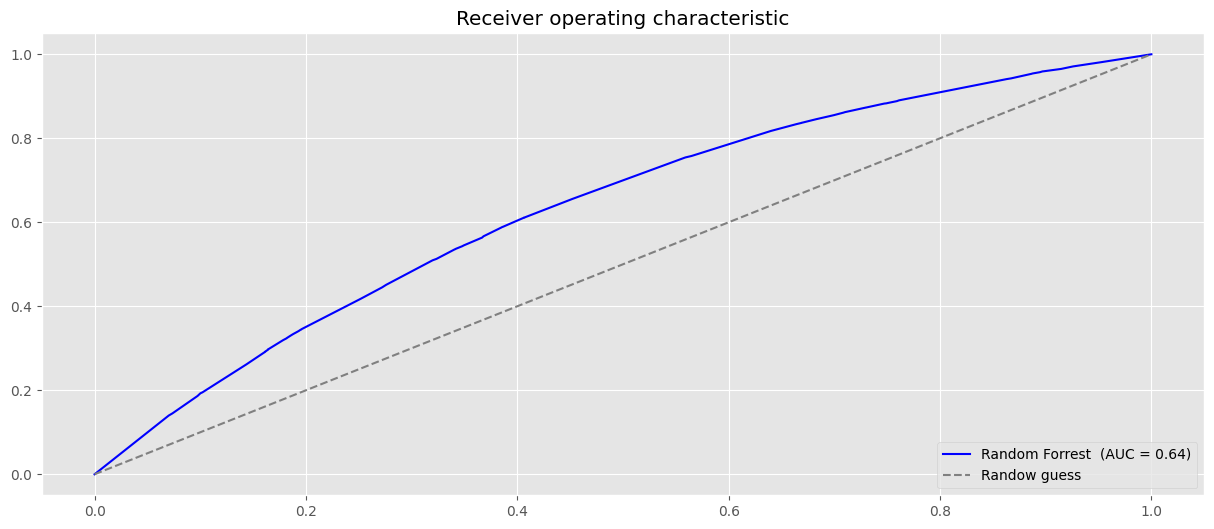

In [5]:
# Curva de ROC RandomForestClassifier
probas1 = clf_rf1.predict_proba(preprocessor.fit_transform(X))[:,1]
fpr, tpr, _ = roc_curve(y, probas1)
#
plt.plot(fpr,tpr, label=f"Random Forrest  (AUC = {auc(fpr, tpr):.2f})", color="blue")
plt.plot((0,1), (0,1), ls = "--", color="grey", label="Randow guess")
plt.legend(loc="lower right")
plt.title("Receiver operating characteristic")
plt.show()

Podemos ver que hay un aumento en AUC usando el algoritmo de bosque aleatorio. Con solo dos covariables, podemos lograr un aumento bastante significativo en el rendimiento. Esta diferencia probablemente sería más pronunciada con más variables.

## ***Modelo con todas las covariables***

In [6]:
df_full = df_prestamos.copy()
df_full.drop(columns=["estado_de_verificacion"], inplace=True)
df_full

,estado_del_prestamo,ingreso_anual,anios_de_experiencia_laboral,tenencia_de_vivienda,tasa_de_interes,monto_del_prestamo,proposito,plazo,calificacion
0,completamente_pagado,24000.0,10+ años,alquiler,10.65,5000,tarjeta_de_credito,36 meses,B
1,dado_de_baja,30000.0,< 1 año,alquiler,15.27,2500,auto,60 meses,C
2,completamente_pagado,12252.0,10+ años,alquiler,15.96,2400,pequeno_negocio,36 meses,C
3,completamente_pagado,49200.0,10+ años,alquiler,13.49,10000,otro,36 meses,C
4,completamente_pagado,80000.0,1 año,alquiler,12.69,3000,otro,60 meses,B
...,...,...,...,...,...,...,...,...,...
38700,completamente_pagado,110000.0,4 años,hipoteca,8.07,2500,remodelacion_del_hogar,36 meses,A
38701,completamente_pagado,18000.0,3 años,alquiler,10.28,8500,tarjeta_de_credito,36 meses,C
38702,completamente_pagado,100000.0,< 1 año,hipoteca,8.07,5000,consolidacion_de_deudas,36 meses,A
38703,completamente_pagado,200000.0,< 1 año,hipoteca,7.43,5000,otro,36 meses,A


In [7]:
categorical_features = [col for col in df_full.select_dtypes(exclude=np.number).columns if col != "estado_del_prestamo"]
numeric_features = [col for col in df_full.columns if col not in categorical_features and col != "estado_del_prestamo"]

preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(sparse_output=False), categorical_features),
        ("num", "passthrough", numeric_features)        
    ]
)

clf_rf_full = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    random_state=123,
    oob_score=True
)

X = df_full[categorical_features + numeric_features]
y = label_binarize(df_full["estado_del_prestamo"], classes=["dado_de_baja", "completamente_pagado"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)
clf_rf_full.fit(preprocessor.fit_transform(X_train), y_train)

RandomForestClassifier(max_depth=3, oob_score=True, random_state=123)

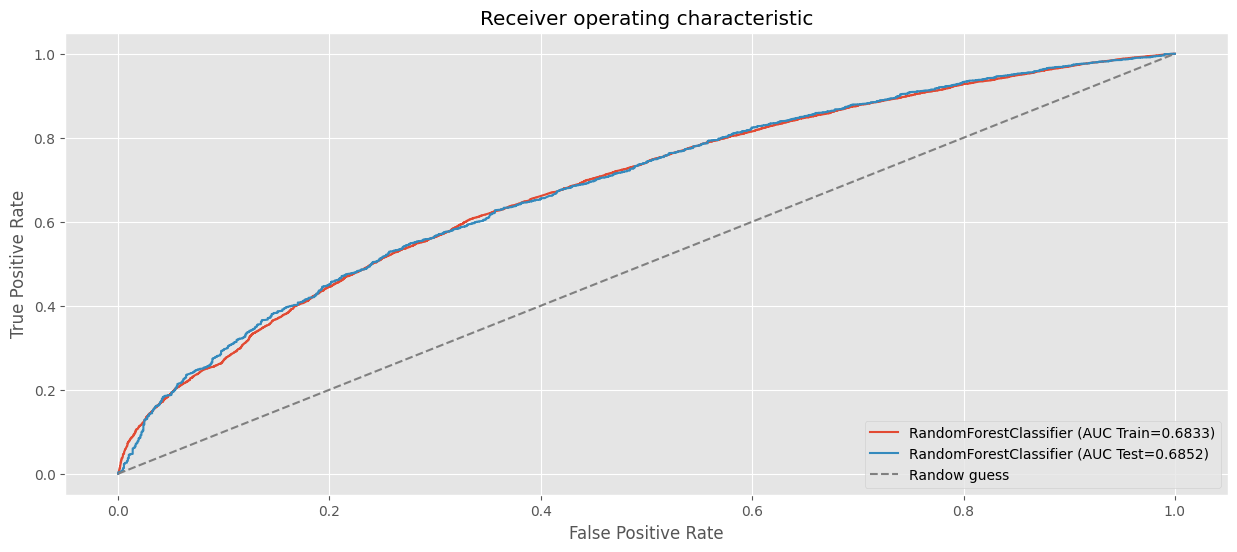

In [8]:
# AUC en train.
fpr, tpr, _ = roc_curve(y_train, clf_rf_full.predict_proba(preprocessor.fit_transform(X_train))[:, 1])
plt.plot(fpr, tpr, label=f"RandomForestClassifier (AUC Train={auc(fpr, tpr):.4f})")

# AUC en test.
fpr, tpr, _ = roc_curve(y_test, clf_rf_full.predict_proba(preprocessor.fit_transform(X_test))[:, 1])
plt.plot(fpr, tpr, label=f"RandomForestClassifier (AUC Test={auc(fpr, tpr):.4f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.plot((0,1), (0,1), ls="--", color="grey", label="Randow guess")
plt.legend(loc="lower right")
plt.show()

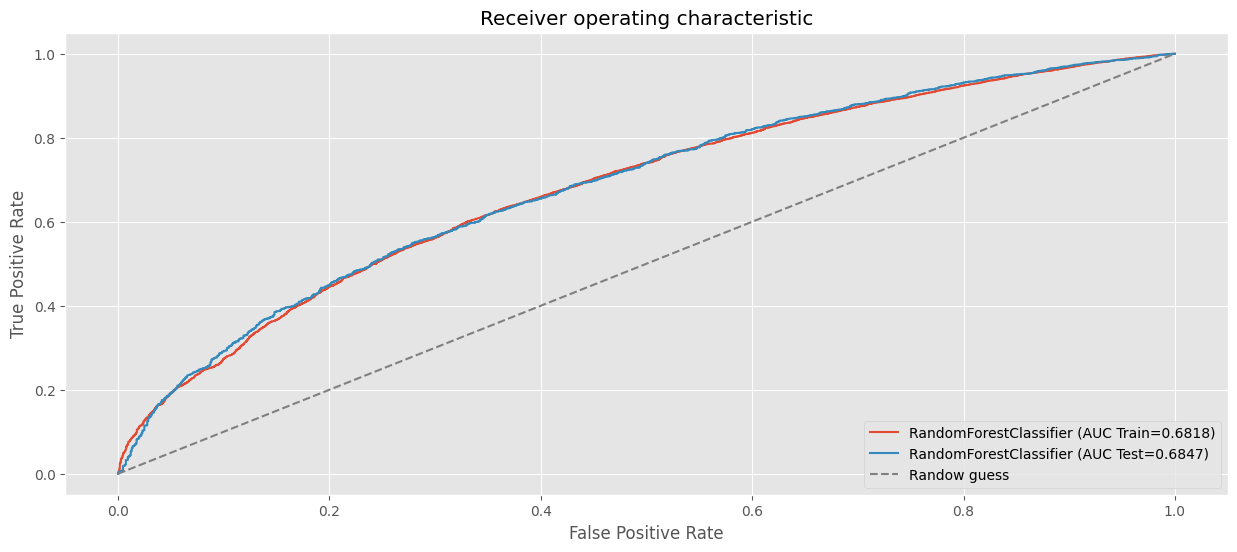

In [9]:
clf_rf_full2 = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    random_state=123,
    oob_score=True,
    min_samples_leaf=300
)

clf_rf_full2.fit(preprocessor.fit_transform(X_train), y_train)

# AUC en train.
fpr, tpr, _ = roc_curve(y_train, clf_rf_full2.predict_proba(preprocessor.fit_transform(X_train))[:, 1])
plt.plot(fpr, tpr, label=f"RandomForestClassifier (AUC Train={auc(fpr, tpr):.4f})")

# AUC en test.
fpr, tpr, _ = roc_curve(y_test, clf_rf_full2.predict_proba(preprocessor.fit_transform(X_test))[:, 1])
plt.plot(fpr, tpr, label=f"RandomForestClassifier (AUC Test={auc(fpr, tpr):.4f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.plot((0,1), (0,1), ls="--", color="grey", label="Randow guess")
plt.legend(loc="lower right")
plt.show()

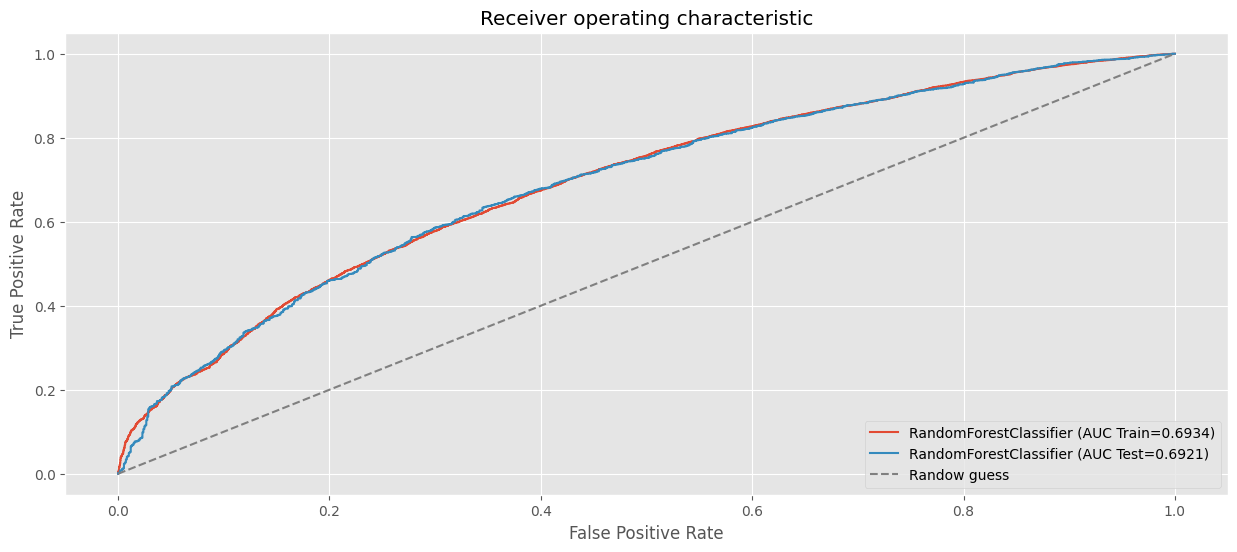

In [10]:
clf_rf_full3 = RandomForestClassifier(
    n_estimators=90,
    criterion="gini",
    max_depth=6,
    random_state=42,
    min_samples_leaf=5,
    min_samples_split=700,
    oob_score=True
)

clf_rf_full3.fit(preprocessor.fit_transform(X_train), y_train)

# AUC en train.
fpr, tpr, _ = roc_curve(y_train, clf_rf_full3.predict_proba(preprocessor.fit_transform(X_train))[:, 1])
plt.plot(fpr, tpr, label=f"RandomForestClassifier (AUC Train={auc(fpr, tpr):.4f})")

# AUC en test.
fpr, tpr, _ = roc_curve(y_test, clf_rf_full3.predict_proba(preprocessor.fit_transform(X_test))[:, 1])
plt.plot(fpr, tpr, label=f"RandomForestClassifier (AUC Test={auc(fpr, tpr):.4f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.plot((0,1), (0,1), ls="--", color="grey", label="Randow guess")
plt.legend(loc="lower right")
plt.show()

## ***Feature Importance en Random Forest***

La ***feature importance*** mide la relevancia de cada característica para las predicciones del modelo. En **Random Forest**, se calcula mediante:

- ***Reducción Promedio de la Impureza (MDI):***
   - Calcula cuánto reduce la impureza (Gini o entropía) al usar una característica para dividir un nodo.
   - Predeterminado en scikit-learn.

#### ***Impacto de las Variables Categóricas***
- Las variables categóricas con muchas categorías o pocas observaciones en ciertas categorías pueden sesgar la importancia. 
- **Categorías poco representadas:**
  - Contribuyen menos al modelo por la falta de información estadística.
  - Pueden aumentar el riesgo de sobreajuste si capturan ruido en lugar de patrones reales.

#### ***Interpretación***
- Valores más altos indican mayor relevancia de una característica.
- Ayuda a identificar las variables clave y eliminar las irrelevantes.

#### ***Ventajas y Limitaciones***
- **Ventajas:** Intuitivo, útil para simplificar modelos.
- **Limitaciones:** 
  1. Sesgo hacia variables categóricas con muchas categorías.
  2. Poca utilidad de categorías infrecuentes.
  3. Dificultad para capturar interacciones.
  4. Dependencia del método (MDI puede sobrestimar).


In [11]:
encoded_categorical_names = preprocessor.named_transformers_["onehot"].get_feature_names_out(categorical_features)
numeric_names = numeric_features
transformed_feature_names = list(encoded_categorical_names) + numeric_names
importances = clf_rf_full3.feature_importances_
importance_df = pd.DataFrame({"Feature": transformed_feature_names, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False).reset_index(drop=True)
importance_df

,Feature,Importance
0,tasa_de_interes,0.297144
1,plazo_ 36 meses,0.132306
2,plazo_ 60 meses,0.131824
3,calificacion_A,0.111486
4,ingreso_anual,0.070003
5,proposito_pequeno_negocio,0.049825
6,calificacion_E,0.033946
7,calificacion_D,0.032778
8,calificacion_F,0.028853
9,calificacion_B,0.021430


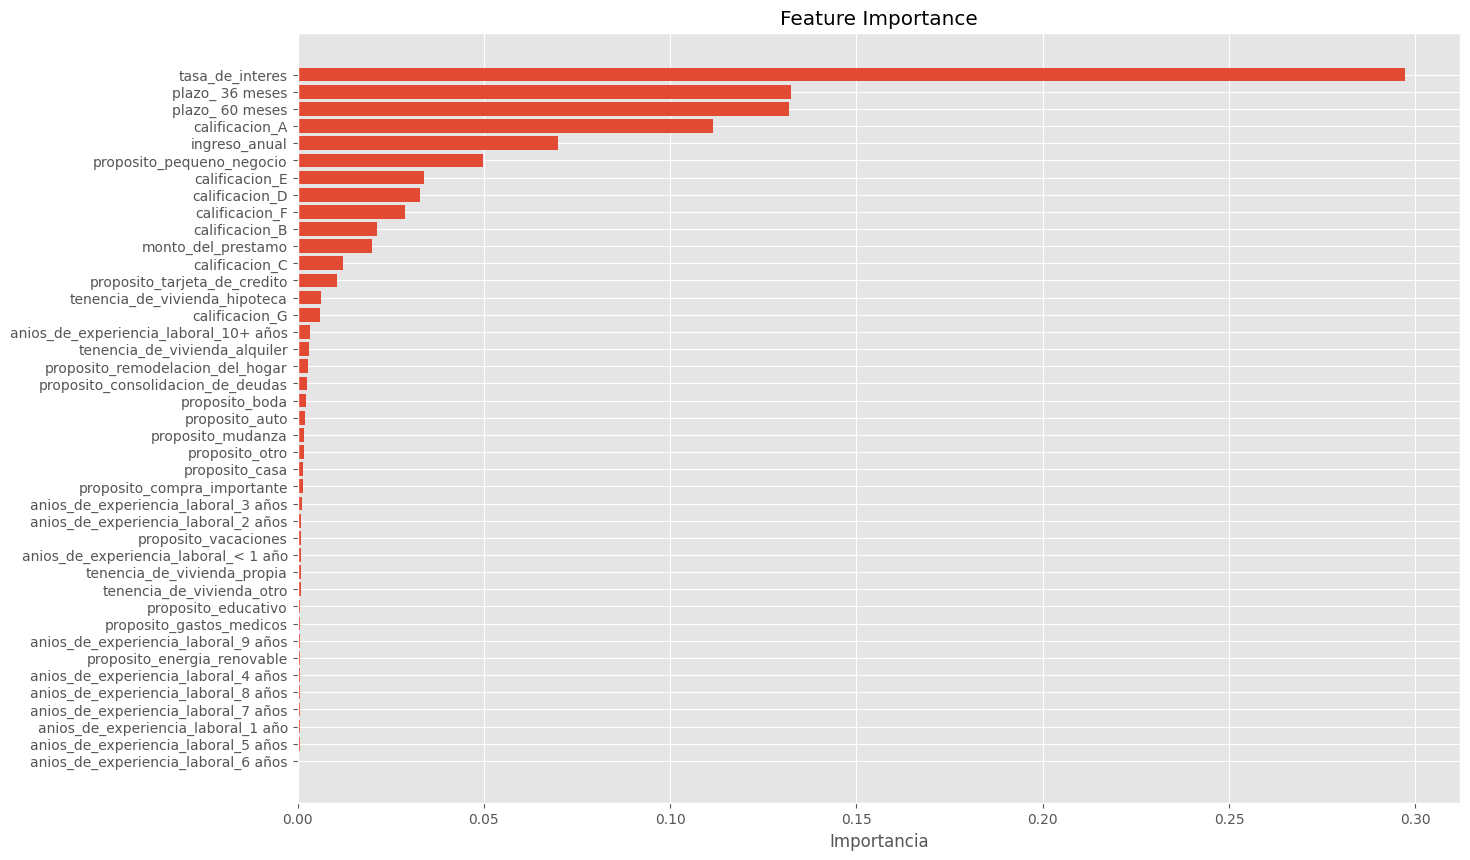

In [12]:
plt.figure(figsize=(15, 10))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importancia")
plt.ylabel("")
plt.title("Feature Importance")
plt.gca().invert_yaxis()
plt.show()

## ***Out-of-Bag (OOB) en Random Forest***

### ***Out-of-Bag Evaluation***

Con _bagging_, algunas instancias se pueden muestrear varias veces para cualquier predictor dado, mientras que otros pueden no ser muestreados en absoluto. Por defecto, un _BaggingClassifier_ toma $m$ registros del set de train con reemplazo (`bootstrap=True`), donde $m$ es el tamaño del conjunto de entrenamiento. Esto significa que solo alrededor del $63\%$ de los registros del set de entrenamiento se muestrean en promedio para cada predictor. El $37\%$ restante de los registros que no son muestreados se denominan registros (instancias) ***out-of-bag (oob)***.


El ***Out-of-Bag (OOB)*** es una técnica útil para evaluar el rendimiento de un modelo de ***Random Forest*** durante el entrenamiento, sin necesidad de un conjunto de validación separado.

#### ***¿Cómo Funciona el OOB?***

1. ***Selección de Datos por Bootstrap:***
   - Cada árbol se entrena con un subconjunto de los datos seleccionados mediante muestreo con reemplazo.
   - Las instancias no seleccionadas forman los datos ***Out-of-Bag (OOB)*** para ese árbol.

2. ***Predicciones OOB:***
   - Cada instancia es evaluada únicamente por los árboles donde no participó durante el entrenamiento.
   - Las predicciones finales de una instancia OOB son agregadas (por voto mayoritario o promedio) de todos los árboles donde fue OOB.

3. ***Cálculo del OOB Score:***
   - Se compara la predicción agregada con las etiquetas reales para calcular una métrica global, como exactitud o AUC.
   - Este puntaje representa una estimación conservadora del rendimiento del modelo.

#### ***¿Por qué el OOB Score puede ser más bajo?***

1. ***Menos Árboles Contribuyen:***
   - El OOB Score usa solo los árboles donde la instancia fue OOB, lo que resulta en menos contribuciones para cada predicción, aumentando la varianza.

2. ***Evaluación Estricta:***
   - Las instancias OOB son tratadas como datos "no vistos" por los árboles que las evalúan, lo que simula un conjunto de validación más estricto.

3. ***Generalización Conservadora:***
   - Al no beneficiarse del conocimiento de todos los árboles, el OOB Score tiende a ser más bajo que el rendimiento en el conjunto de entrenamiento o incluso en un conjunto de prueba separado.


#### ***Notas:***

- ***Evaluación Comparable:*** Aunque es más conservador, el OOB Score puede reflejar mejor cómo el modelo generalizará en datos no vistos.

- ***Sesgo en Datos Desbalanceados:*** En conjuntos con clases altamente desbalanceadas, el OOB Score puede subestimar el rendimiento real debido al sesgo hacia la clase mayoritaria.

- ***No Sustituye al Conjunto de Prueba:*** Si bien es útil como estimación inicial, el OOB Score no reemplaza la evaluación en un conjunto de prueba externo para medir la capacidad de generalización.


In [13]:
pd.DataFrame(clf_rf_full3.oob_decision_function_)

,0,1
0,0.142356,0.857644
1,0.066600,0.933400
2,0.282172,0.717828
3,0.253039,0.746961
4,0.107753,0.892247
...,...,...
30946,0.152940,0.847060
30947,0.142514,0.857486
30948,0.197629,0.802371
30949,0.081787,0.918213


In [14]:
pd.DataFrame(clf_rf_full3.predict_proba(preprocessor.fit_transform(X_train)))

,0,1
0,0.143918,0.856082
1,0.066585,0.933415
2,0.280503,0.719497
3,0.258214,0.741786
4,0.107117,0.892883
...,...,...
30946,0.149155,0.850845
30947,0.143554,0.856446
30948,0.184611,0.815389
30949,0.098721,0.901279


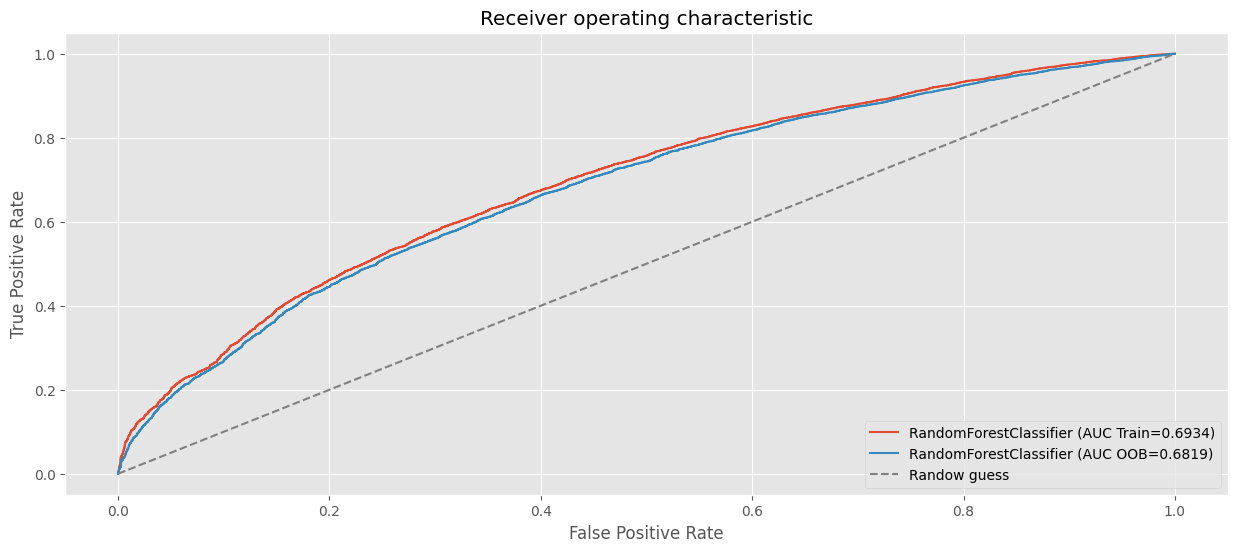

In [15]:
# AUC en train.
fpr, tpr, _ = roc_curve(y_train, clf_rf_full3.predict_proba(preprocessor.fit_transform(X_train))[:, 1])
plt.plot(fpr, tpr, label=f"RandomForestClassifier (AUC Train={auc(fpr, tpr):.4f})")

# AUC en test.
fpr, tpr, _ = roc_curve(y_train, clf_rf_full3.oob_decision_function_[:, 1])
plt.plot(fpr, tpr, label=f"RandomForestClassifier (AUC OOB={auc(fpr, tpr):.4f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.plot((0,1), (0,1), ls="--", color="grey", label="Randow guess")
plt.legend(loc="lower right")
plt.show()

### ***¿Cómo Elegir un Modelo de Clasificación?***

La elección del modelo de clasificación depende de múltiples factores, siendo el rendimiento predictivo, como el AUC (Área bajo la curva), uno de los más importantes. Sin embargo, cuando el rendimiento de los modelos es similar, como en este caso, donde todos los modelos tienen resultados comparables, la decisión puede basarse en otros criterios como la varianza, la eficiencia computacional y el propósito del análisis.


***Criterios para la Selección del Modelo***

1. ***Finalidad del análisis***
    - Si buscas un clasificador rápido y sencillo, los bosques aleatorios son una buena opción con configuraciones predeterminadas.
    - Si los datos tienen patrones bien entendidos, podrías usar la regresión logística con transformaciones manuales para capturar esos patrones.

2. ***Tamaño del conjunto de datos***
- Con grandes volúmenes de datos:
  - Los bosques aleatorios y la regresión logística pueden volverse computacionalmente costosos debido a su complejidad.
  - Los bosques aleatorios son más adecuados cuando los datos son ricos y tienen interacciones complejas, aunque entrenarlos en grandes conjuntos de datos requiere más recursos.

3. ***Número de covariables***
- Cuando el número de covariables es pequeño, tanto los bosques aleatorios como la regresión logística se desempeñan bien.
- A medida que aumenta el número de covariables:
  - Los bosques aleatorios capturan mejor las interacciones complejas.
  - La regresión logística podría requerir regularización para evitar sobreajuste.

## ***Conclusiones***

1. ***Diferencias entre modelos***
    - Los bosques aleatorios son más lentos, pero capturan relaciones no lineales y patrones complejos en los datos.
    - La regresión logística, aunque más rápida y directa, puede no capturar interacciones no lineales sin agregar transformaciones explícitas.

2. ***Desempeño similar en el caso actual***
    - Ambos modelos mostraron un desempeño similar debido al tamaño mediano del conjunto de datos y el número limitado de covariables.
    - La ausencia de sobreajuste sugiere que los datos son suficientes para un entrenamiento adecuado sin complejidad adicional.

3. ***Extensibilidad de los modelos***

    - **Bosques aleatorios:**
      - Requieren ajuste fino de parámetros, como el número de árboles y la profundidad, para optimizar el desempeño según las características de los datos.
    - **Regresión logística:**
      - Puede beneficiarse de la regularización y es más adecuada para conjuntos de datos más pequeños y con menor complejidad.




4. ***La selección del modelo debe considerar el equilibrio entre:***
    - **Propósito del análisis:** ¿Es una prueba rápida o un modelo optimizado para producción?
    - **Eficiencia computacional:** ¿Cuántos datos y covariables tiene el problema?
    - **Capacidad del modelo para generalizar:** ¿Los datos son lo suficientemente ricos para aprovechar modelos más complejos?

#### ***Hiperparámetros de Random Forest en Scikit-learn: Recomendaciones y Explicaciones***

Un **Random Forest** es un modelo basado en árboles de decisión que utiliza el principio de ensembles para mejorar la precisión y reducir el sobreajuste. A continuación, se describen los hiperparámetros principales, incluidas las recomendaciones para optimizarlos:


- `n_estimators`
- **Descripción**: Número de árboles en el bosque.
- **Recomendación**:
  - Comienza con **100** y aumenta hasta que el rendimiento se estabilice (e.g., 200-500).
  - Más árboles ofrecen más estabilidad, pero aumentan el tiempo de cómputo.


- `criterion`
- **Descripción**: Función para medir la calidad de una división.
- **Opciones**:
  - **`gini`**: Índice de Gini (predeterminado). Mide la impureza de las particiones.
  - **`entropy`**: Ganancia de información. Basado en la reducción de entropía.
  - **`log_loss`**: Pérdida logarítmica (desde Scikit-learn 1.1). Permite obtener probabilidades calibradas.
- **Recomendación**:
  - Usa **`gini`** como punto de partida para la mayoría de los problemas.
  - Experimenta con **`entropy`** si prefieres divisiones basadas en entropía.
  - Usa **`log_loss`** si necesitas probabilidades calibradas o si el modelo debe ser compatible con métricas de puntuación probabilística (e.g., log-loss o Brier score).
- **Nota**: `log_loss` es útil para clasificación multiclase y puede ser más robusto cuando las clases están desbalanceadas.


- `max_depth`
- **Descripción**: Profundidad máxima de cada árbol.
- **Recomendación**:
  - Usa valores entre **5 y 20** para evitar el sobreajuste.
  - Si no se especifica, los árboles crecen hasta que las hojas sean puras.
  - Limitar la profundidad es útil para datos ruidosos.


- `min_samples_split`
- **Descripción**: Número mínimo de muestras para dividir un nodo.
- **Recomendación**:
  - Valor predeterminado: **2**.
  - Para evitar divisiones con pocas observaciones, utiliza valores más altos, como **0.01** del total de datos.


- `min_samples_leaf`
- **Descripción**: Mínimo de muestras en una hoja.
- **Recomendación**:
  - Valores pequeños (**1-5**) para datos grandes.
  - Valores más altos (**10-50**) en datos ruidosos para árboles más simples.


- `max_features`
- **Descripción**: Número máximo de características consideradas en cada división.
- **Recomendación**:
  - Clasificación: Usa `"sqrt"` (raíz cuadrada del total de variables).
  - Para alta dimensionalidad: Usa `"log2"` o valores pequeños.
  - Predeterminado (`auto`) funciona bien para la mayoría de los casos.


- `bootstrap`
- **Descripción**: Si usar muestreo con reemplazo.
- **Recomendación**:
  - Usa `True` (predeterminado) para conjuntos grandes.
  - Cambia a `False` para conjuntos de datos pequeños.


- `class_weight`
- **Descripción**: Pesos de las clases en problemas de clasificación.
- **Recomendación**:
  - Usa `"balanced"` si hay desbalance entre las clases.
  - Asigna pesos personalizados si tienes conocimiento previo sobre su importancia.